In [1]:
"""
Notebook to produce appendix figures for my master thesis at the University of Amsterdam.

Part of the data is not public yet. Feel free to email me at s.j.i.melfor@uva.nl if you
are interested in the data.

Author: Selah Melfor

This software is provided under license: Creative Commons Attribution 4.0
International (https://creativecommons.org/licenses/by/4.0/legalcode) and is provided as-is.

"""

# import packages
import os
import json
import pickle
import numpy as np
import bilby
import corner

import astropy.units as u
import astropy.constants as const
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon
from pesummary.io import read
from pesummary.utils.samples_dict import MultiAnalysisSamplesDict
from pesummary.utils.bounded_1d_kde import bounded_1d_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

# set style of plots
plt.style.use("science.mplstyle")

# set colors for plots
COLORS_DICT = {
    "teal"     : "#00707e",
    "darkred"  : "#8a0000",
    "gray"     : "#b0a8a8",
    "blue"     : "#00b9f2",
    "orange"   : "#f2a02a",
    "red"      : "#f94730",
    "green"    : "#c6de81",
    "pink"     : "#f8b7c9",
    "navy"     : "#1c4484",
    "black"    : "#0f0101",
}

# Figure widths in line with journal guidelines
FIG_SIZES = {
    "rectangle_plot"                 : (3.39 * 2 * 0.8, 2.64 * 1.5 * 0.8),
    "square_plot"                    : (2.64 * 1.5 * 0.8, 2.64 * 1.5 * 0.8),
    "rectangle_plot_spectogram"      : (3.39 * 4 * 0.8, 2.64 * 1.2 * 0.8),
    "rectangle_plot_two_a_side"      : (3.39 * 3.5 * 0.8, 2.64 * 1.2 * 0.8),
}

# Linewidths must be >0.5 to fit journal specs
LINEWIDTHS = {
    "interval" : 0.7,
    "curve"    : 0.9,
    "line"     : 0.6,
}

# Lower and upper limits in credible intervals 
CONFIDENCE_LIMITS = {
    "lower_bound" : 5,
    "median"      : 50,
    "upper_bound" : 95,
}

# Levels used for contours
CONTOUR_LEVELS = {
    "min" : 0.0,
    "mid" : 0.5,
    "max" : 0.9,
}

# Display plots
%matplotlib inline 

/home/smelfor/anaconda3/envs/plotting_env/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
data_dir = 'data/'
figures_dir = 'appendix_figures/'

# data path for the 
case_studies_dir        = data_dir + 'case_studies/'
population_studies_dir  = data_dir + 'population_studies/'
theory_data_dir         = data_dir + 'theoretical_background/'
methodology_data_dir    = data_dir + 'methodology/'
introduction_data_dir   = data_dir + 'introduction/'
discussion_data_dir     = data_dir + 'discussion/'

# save path for the figures
case_studies_dir                  = figures_dir + 'theoretical_background/'
methodology_dir             = figures_dir + 'methodology/'
results_case_studies_dir    = figures_dir + 'results/case_studies/'
results_population_dir      = figures_dir + 'results/population_studies/'
introduction_dir            = figures_dir + 'introduction/'
discussion_dir              = figures_dir + 'discussion/'

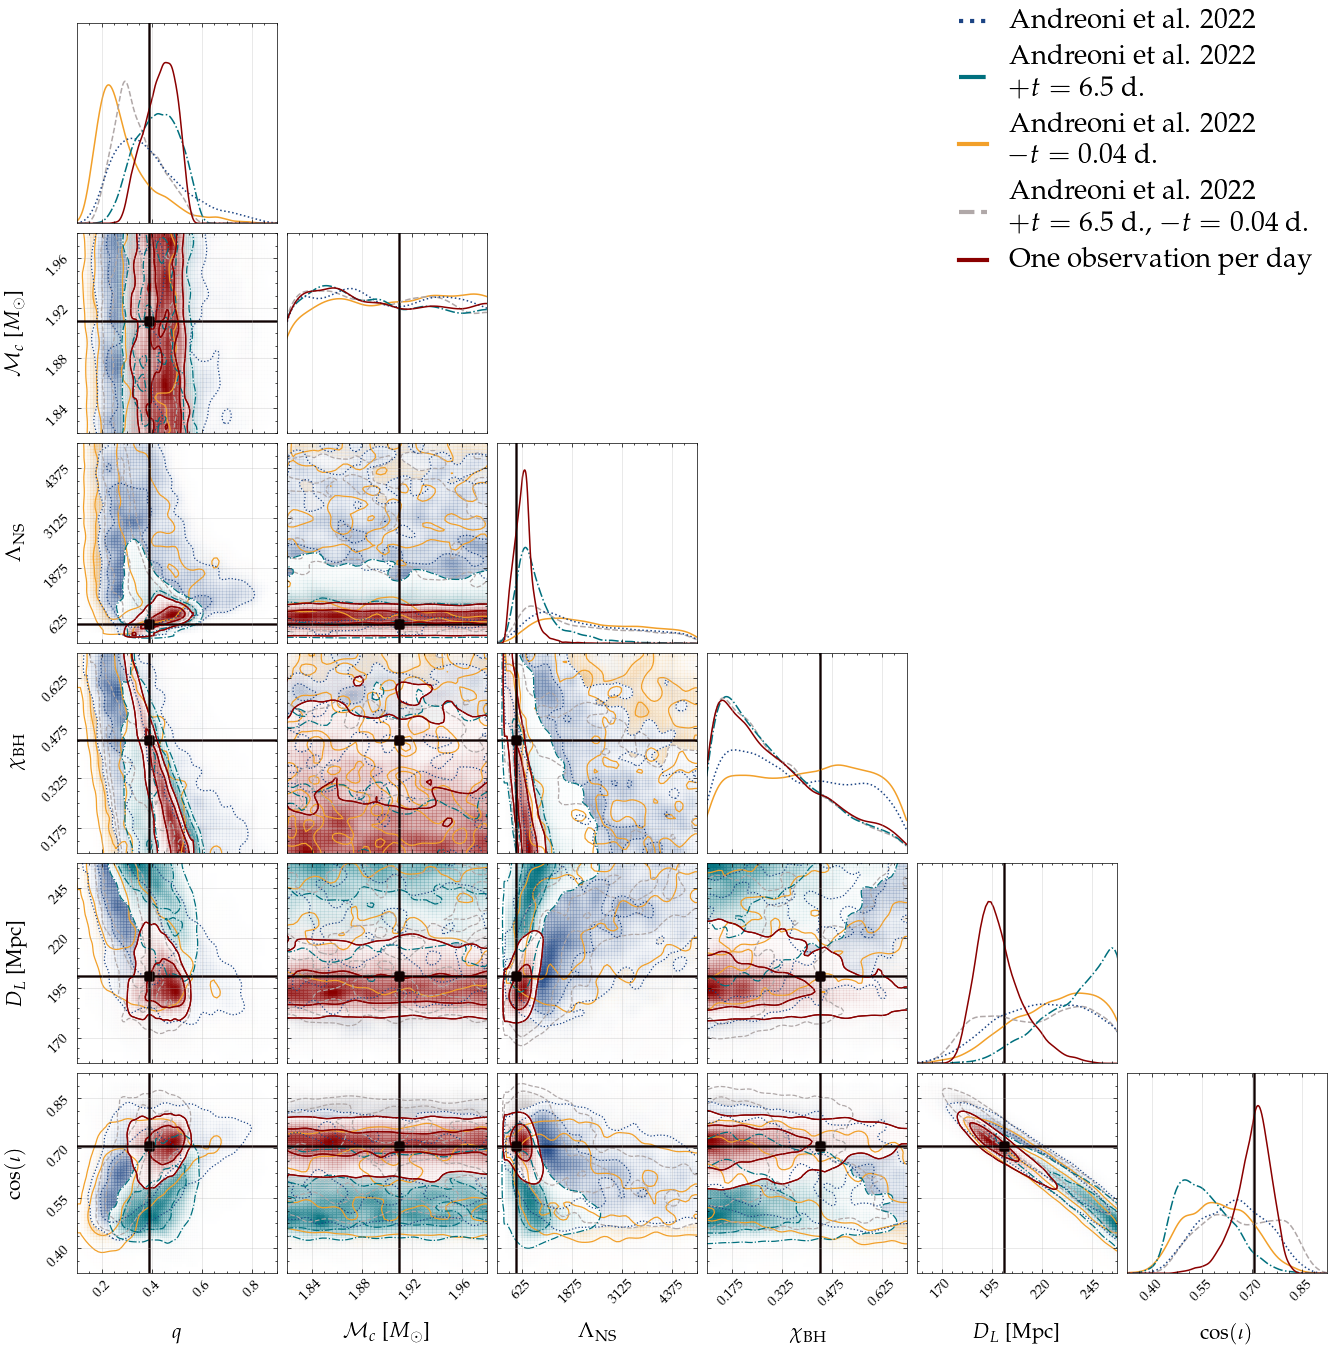

In [6]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
label_key = ['andreoni_preferred_strategy_without_early_times', 'andreoni_preferred_strategy_without_early_times_with_late_time_obs',
             'andreoni_preferred_strategy', 'andreoni_preferred_strategy_with_late_time_obs', 'one_observation_per_day']

results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_1/{label}/em_run/', label='em') for i, label in enumerate(label_key)]

COLORS_RUNS = {'andreoni_preferred_strategy_without_early_times_with_late_time_obs' : COLORS_DICT['gray'],
               'one_observation_per_day'                                            : COLORS_DICT['darkred'],
               'andreoni_preferred_strategy'                                        : COLORS_DICT['navy'],
               'andreoni_preferred_strategy_with_late_time_obs'                     : COLORS_DICT['teal'],
               'andreoni_preferred_strategy_without_early_times'                    : COLORS_DICT['orange']}

LINESTYLE_RUNS = {'andreoni_preferred_strategy_without_early_times_with_late_time_obs'  : '--',
               'one_observation_per_day'                                                : '-',
               'andreoni_preferred_strategy'                                            : ':',
               'andreoni_preferred_strategy_with_late_time_obs'                         : '-.',
               'andreoni_preferred_strategy_without_early_times'                        : '-'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'chirp_mass', 'lambda_2', 'chi_1', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\mathcal{M}_c$ [$M_\odot$]', r'$\Lambda_{\rm NS}$', r'$\chi_{\rm BH}$', '$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 1.9102896946252306, 490.32033763361954, 0.44, 201, 0.707]

for i, label in enumerate(label_key):

    if i == 0:
        fig = corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = LINESTYLE_RUNS[label]),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
        )

    else:

        corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": '-', "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_chirp_mass              = [gaussian_kde(results_list[i].posterior["chirp_mass"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_chi_1                   = [gaussian_kde(results_list[i].posterior["chi_1"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_chirp_mass, kde_lambda_2, kde_chi_1, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(1.8, 2.1, 1000), np.linspace(0, 5000, 1000), 
               np.linspace(0.1, 0.7, 1000), np.linspace(150, 280, 100),  np.linspace(0.1, 1, 1000)]

mass_ratio_ticks            = [0.2, 0.4, 0.6, 0.8]
chirp_mass_ticks            = [1.84, 1.88, 1.92, 1.96]
lambda_2_ticks              = [625, 1875, 3125, 4375]
chi_1_ticks                 = [0.175, 0.325, 0.475, 0.625]
luminosity_distance_ticks   = [170, 195, 220, 245]
cos_theta_jn_ticks          = [0.4, 0.55, 0.7, 0.85]


for j, axes in enumerate([0, 7, 14, 21, 28, 35]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[6].set_xticks(mass_ratio_ticks)
fig.get_axes()[6].set_yticks(chirp_mass_ticks)

# lambda_2 1D distribution
fig.get_axes()[7].set_xticks(chirp_mass_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(lambda_2_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[13].set_xticks(chirp_mass_ticks)
fig.get_axes()[13].set_yticks(lambda_2_ticks)

# mwind 1D distribution
fig.get_axes()[14].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[18].set_xticks(mass_ratio_ticks)
fig.get_axes()[18].set_yticks(chi_1_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[19].set_xticks(chirp_mass_ticks)
fig.get_axes()[19].set_yticks(chi_1_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[20].set_xticks(lambda_2_ticks)
fig.get_axes()[20].set_yticks(chi_1_ticks)

# mwind 1D distribution
fig.get_axes()[21].set_xticks(chi_1_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[24].set_xticks(mass_ratio_ticks)
fig.get_axes()[24].set_yticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[25].set_xticks(chirp_mass_ticks)
fig.get_axes()[25].set_yticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[26].set_xticks(lambda_2_ticks)
fig.get_axes()[26].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[27].set_xticks(chi_1_ticks)
fig.get_axes()[27].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[28].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[30].set_xticks(mass_ratio_ticks)
fig.get_axes()[30].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[31].set_xticks(chirp_mass_ticks)
fig.get_axes()[31].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[32].set_xticks(lambda_2_ticks)
fig.get_axes()[32].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[33].set_xticks(chi_1_ticks)
fig.get_axes()[33].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[34].set_xticks(luminosity_distance_ticks)
fig.get_axes()[34].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[35].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.1, 0.9
chirp_mass_min, chirp_mass_max                       = 1.82, 1.98
lambda_2_min, lambda_2_max                           = 0, 5000
chi_1_min, chi_1_max                                 = 0.1, 0.7
luminosity_distance_min, luminosity_distance_max     = 170 - 12.5, 245 + 12.5
cos_theta_jn_min, cos_theta_jn_max                   = 0.4 - 0.075, 0.85 + 0.075

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim([mass_ratio_min, mass_ratio_max])

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[6].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[6].set_ylim([chirp_mass_min, chirp_mass_max])

# lambda_2 1D distribution
fig.get_axes()[7].set_xlim([chirp_mass_min, chirp_mass_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[12].set_ylim([lambda_2_min, lambda_2_max])

# vdyn-mwind 2D distribution
fig.get_axes()[13].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[13].set_ylim([lambda_2_min, lambda_2_max])

# mwind 1D distribution
fig.get_axes()[14].set_xlim([lambda_2_min, lambda_2_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[18].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[18].set_ylim([chi_1_min, chi_1_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[19].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[19].set_ylim([chi_1_min, chi_1_max])

# vdyn-mwind 2D distribution
fig.get_axes()[20].set_xlim([lambda_2_min, lambda_2_max])
fig.get_axes()[20].set_ylim([chi_1_min, chi_1_max])

# mwind 1D distribution
fig.get_axes()[21].set_xlim([chi_1_min, chi_1_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[24].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[24].set_ylim([luminosity_distance_min, luminosity_distance_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[25].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[25].set_ylim([luminosity_distance_min, luminosity_distance_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[26].set_xlim([lambda_2_min, lambda_2_max])
fig.get_axes()[26].set_ylim([luminosity_distance_min, luminosity_distance_max])

# vdyn-mwind 2D distribution
fig.get_axes()[27].set_xlim([chi_1_min, chi_1_max])
fig.get_axes()[27].set_ylim([luminosity_distance_min, luminosity_distance_max])

# mwind 1D distribution
fig.get_axes()[28].set_xlim([luminosity_distance_min, luminosity_distance_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[30].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[30].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[31].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[31].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[32].set_xlim([lambda_2_min, lambda_2_max])
fig.get_axes()[32].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# vdyn-mwind 2D distribution
fig.get_axes()[33].set_xlim([chi_1_min, chi_1_max])
fig.get_axes()[33].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# vdyn-mwind 2D distribution
fig.get_axes()[34].set_xlim([luminosity_distance_min, luminosity_distance_max])
fig.get_axes()[34].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# mwind 1D distribution
fig.get_axes()[35].set_xlim([cos_theta_jn_min, cos_theta_jn_max])

labels_legend = ['Andreoni et al. 2022',
                 'Andreoni et al. 2022\n $+ t = 6.5$ d.', 
                 'Andreoni et al. 2022\n\t $- t = 0.04$ d.',
                 'Andreoni et al. 2022\n\t $+ t = 6.5$ d., $- t = 0.04$ d.',
                 'One observation per day'
                 ]

labels = ['andreoni_preferred_strategy', 'andreoni_preferred_strategy_with_late_time_obs',
          'andreoni_preferred_strategy_without_early_times', 'andreoni_preferred_strategy_without_early_times_with_late_time_obs', 'one_observation_per_day']

handles = [Line2D([], [], color=COLORS_RUNS[key], ls=LINESTYLE_RUNS[key]) for key in labels]
legend = plt.legend(handles, labels_legend, loc=(-0.90, 4.97), fontsize=20)
for i in legend.legend_handles:
    i.set_linewidth(3)

matplotlib.rcParams['axes.formatter.useoffset'] = False

fig.savefig(figures_dir + "case_studies/case_study_1_em_corner_plot_too_comparison.pdf")
fig.savefig(figures_dir + "case_studies/case_study_1_em_corner_plot_too_comparison.png")

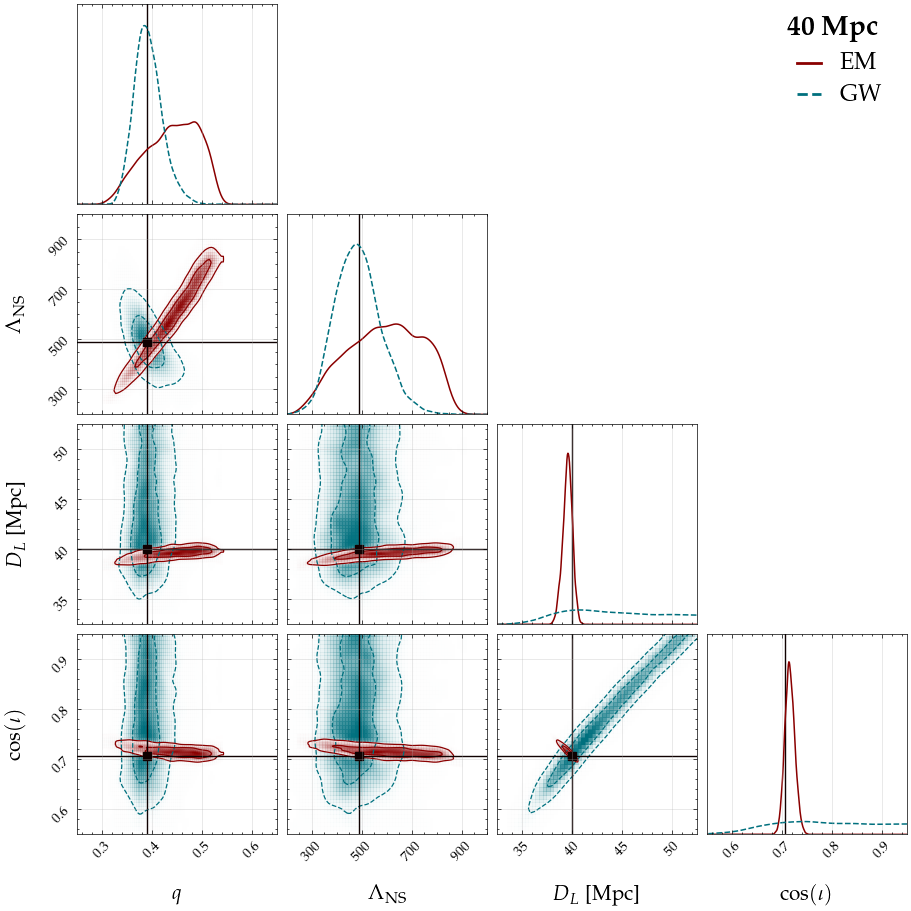

In [17]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['em', 'gw', ]
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/40_Mpc/em_run', label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/40_Mpc/gw_run', label='gw')]
COLORS_RUNS = {'em'               : COLORS_DICT['darkred'],
               'gw'               : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'em'        : '-',
                  'gw'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 40, 0.707]

fig = corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['gw'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['gw'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['em'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['em'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(10, 60, 1000), np.linspace(0.1, 1, 1000)]

mass_ratio_ticks            = [0.3, 0.4, 0.5, 0.6]
lambda_2_ticks              = [300, 500, 700, 900]
luminosity_distance_ticks   = [35, 40, 45, 50]
cos_theta_jn_ticks          = [0.6, 0.7, 0.8, 0.9]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.25, 0.65
lambda_2_min, lambda_2_max                           = 200, 1000
luminosity_distance_min, luminosity_distance_max     = 35 - 2.5, 50 + 2.5
cos_theta_jn_min, cos_theta_jn_max                   = 0.55, 0.95
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['EM', 'GW']
legend = plt.legend(handles, labels, loc=(0.4, 3.62), fontsize=17)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{40 Mpc}",
            xy=(0.4, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(figures_dir + "case_studies/case_study_2_corner_plot_comparison_distances_40Mpc.pdf")
fig.savefig(figures_dir + "case_studies/case_study_2_corner_plot_comparison_distances_40Mpc.png")


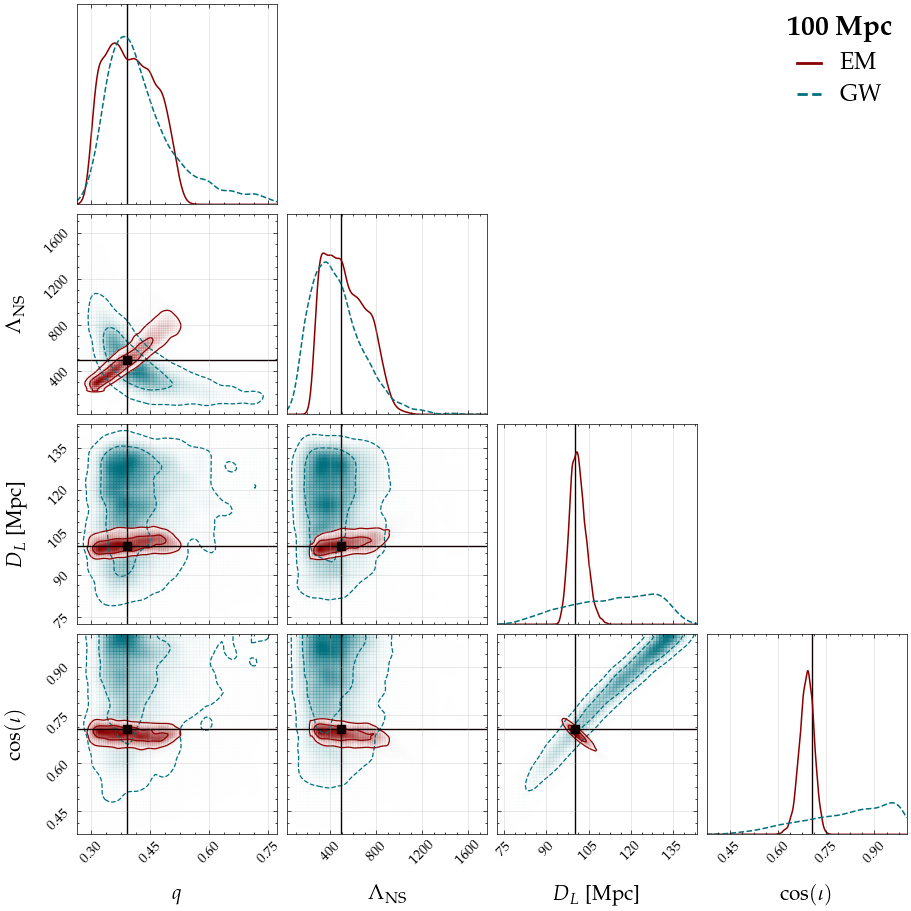

In [16]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['em', 'gw', ]
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/100_Mpc/em_run', label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/100_Mpc/gw_run', label='gw')]
COLORS_RUNS = {'em'               : COLORS_DICT['darkred'],
               'gw'               : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'em'        : '-',
                  'gw'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 100, 0.707]

fig = corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['gw'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['gw'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['em'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['em'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(70, 170, 1000), np.linspace(0.1, 1, 1000)]

# mass_ratio_ticks            = [0.3, 0.4, 0.5, 0.6]
# lambda_2_ticks              = [300, 500, 700, 900]
# luminosity_distance_ticks   = [35, 40, 45, 50]
# cos_theta_jn_ticks          = [0.6, 0.7, 0.8, 0.9]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# # mass_ratio 1D-distribution
# fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# # mass_ratio-lambda_2 2D distribution
# fig.get_axes()[4].set_xticks(mass_ratio_ticks)
# fig.get_axes()[4].set_yticks(lambda_2_ticks)

# # lambda_2 1D distribution
# fig.get_axes()[5].set_xticks(lambda_2_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[8].set_xticks(mass_ratio_ticks)
# fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[9].set_xticks(lambda_2_ticks)
# fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# # mwind 1D distribution
# fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[12].set_xticks(mass_ratio_ticks)
# fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[13].set_xticks(lambda_2_ticks)
# fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
# fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# # mwind 1D distribution
# fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# # Tune x and y limits
# mass_ratio_min, mass_ratio_max                       = 0.25, 0.65
# lambda_2_min, lambda_2_max                           = 200, 1000
# luminosity_distance_min, luminosity_distance_max     = 35 - 2.5, 50 + 2.5
# cos_theta_jn_min, cos_theta_jn_max                   = 0.55, 0.95
# # mwind_min, mwind_max        =  0.016, 0.024

# # mass_ratio 1D-distribution
# fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# # mass_ratio-lambda_2 2D distribution
# fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
# fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# # lambda_2 1D distribution
# fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
# fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# # vdyn-mwind 2D distribution
# fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
# fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# # mwind 1D distribution
# fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
# fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
# fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# # vdyn-mwind 2D distribution
# fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
# fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# # mwind 1D distribution
# fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['EM', 'GW']
legend = plt.legend(handles, labels, loc=(0.4, 3.62), fontsize=17)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{100 Mpc}",
            xy=(0.4, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(figures_dir + "case_studies/case_study_2_corner_plot_comparison_distances_100Mpc.pdf")
fig.savefig(figures_dir + "case_studies/case_study_2_corner_plot_comparison_distances_100Mpc.png")


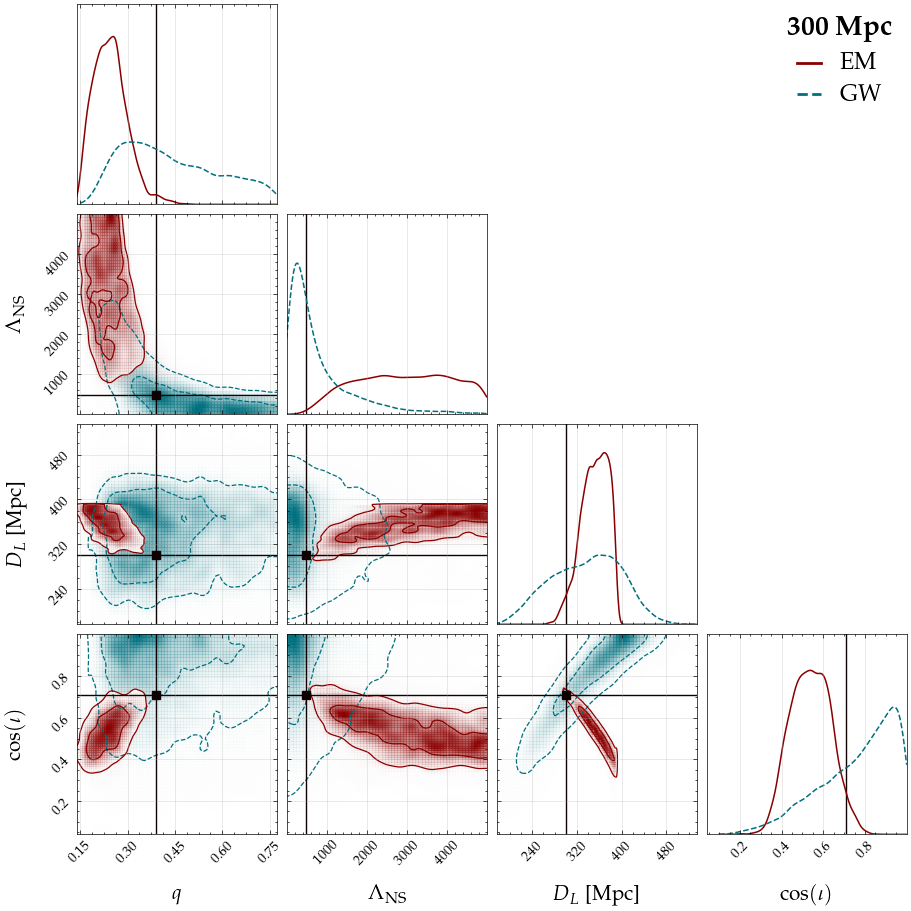

In [20]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['em', 'gw', ]
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/300_Mpc/em_run', label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/300_Mpc/gw_run', label='gw')]
COLORS_RUNS = {'em'               : COLORS_DICT['darkred'],
               'gw'               : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'em'        : '-',
                  'gw'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 300, 0.707]

fig = corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['gw'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['gw'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['em'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['em'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 5000, 3000), 
               np.linspace(100, 600, 1000), np.linspace(0.1, 1, 1000)]

# mass_ratio_ticks            = [0.3, 0.4, 0.5, 0.6]
# lambda_2_ticks              = [300, 500, 700, 900]
# luminosity_distance_ticks   = [35, 40, 45, 50]
# cos_theta_jn_ticks          = [0.6, 0.7, 0.8, 0.9]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# # mass_ratio 1D-distribution
# fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# # mass_ratio-lambda_2 2D distribution
# fig.get_axes()[4].set_xticks(mass_ratio_ticks)
# fig.get_axes()[4].set_yticks(lambda_2_ticks)

# # lambda_2 1D distribution
# fig.get_axes()[5].set_xticks(lambda_2_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[8].set_xticks(mass_ratio_ticks)
# fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[9].set_xticks(lambda_2_ticks)
# fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# # mwind 1D distribution
# fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[12].set_xticks(mass_ratio_ticks)
# fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[13].set_xticks(lambda_2_ticks)
# fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
# fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# # mwind 1D distribution
# fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# # Tune x and y limits
# mass_ratio_min, mass_ratio_max                       = 0.25, 0.65
# lambda_2_min, lambda_2_max                           = 200, 1000
# luminosity_distance_min, luminosity_distance_max     = 35 - 2.5, 50 + 2.5
# cos_theta_jn_min, cos_theta_jn_max                   = 0.55, 0.95
# # mwind_min, mwind_max        =  0.016, 0.024

# # mass_ratio 1D-distribution
# fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# # mass_ratio-lambda_2 2D distribution
# fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
# fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# # lambda_2 1D distribution
# fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
# fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# # vdyn-mwind 2D distribution
# fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
# fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# # mwind 1D distribution
# fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
# fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
# fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# # vdyn-mwind 2D distribution
# fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
# fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# # mwind 1D distribution
# fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['EM', 'GW']
legend = plt.legend(handles, labels, loc=(0.4, 3.62), fontsize=17)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{300 Mpc}",
            xy=(0.4, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(figures_dir + "case_studies/case_study_2_corner_plot_comparison_distances_300Mpc.pdf")
fig.savefig(figures_dir + "case_studies/case_study_2_corner_plot_comparison_distances_300Mpc.png")


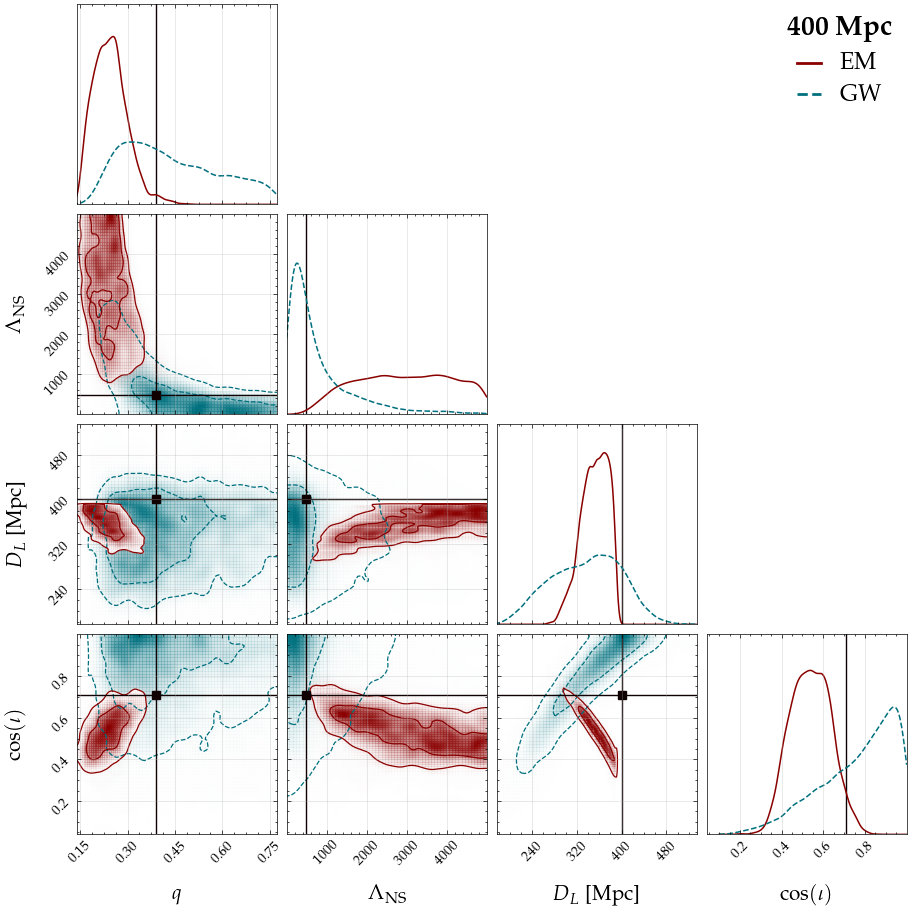

In [22]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['em', 'gw', ]
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/300_Mpc/em_run', label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/300_Mpc/gw_run', label='gw')]
COLORS_RUNS = {'em'               : COLORS_DICT['darkred'],
               'gw'               : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'em'        : '-',
                  'gw'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 400, 0.707]

fig = corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['gw'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['gw'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['em'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['em'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 5000, 3000), 
               np.linspace(100, 700, 1000), np.linspace(0.1, 1, 1000)]

# mass_ratio_ticks            = [0.3, 0.4, 0.5, 0.6]
# lambda_2_ticks              = [300, 500, 700, 900]
# luminosity_distance_ticks   = [35, 40, 45, 50]
# cos_theta_jn_ticks          = [0.6, 0.7, 0.8, 0.9]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# # mass_ratio 1D-distribution
# fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# # mass_ratio-lambda_2 2D distribution
# fig.get_axes()[4].set_xticks(mass_ratio_ticks)
# fig.get_axes()[4].set_yticks(lambda_2_ticks)

# # lambda_2 1D distribution
# fig.get_axes()[5].set_xticks(lambda_2_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[8].set_xticks(mass_ratio_ticks)
# fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[9].set_xticks(lambda_2_ticks)
# fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# # mwind 1D distribution
# fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[12].set_xticks(mass_ratio_ticks)
# fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[13].set_xticks(lambda_2_ticks)
# fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
# fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# # mwind 1D distribution
# fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# # Tune x and y limits
# mass_ratio_min, mass_ratio_max                       = 0.25, 0.65
# lambda_2_min, lambda_2_max                           = 200, 1000
# luminosity_distance_min, luminosity_distance_max     = 35 - 2.5, 50 + 2.5
# cos_theta_jn_min, cos_theta_jn_max                   = 0.55, 0.95
# # mwind_min, mwind_max        =  0.016, 0.024

# # mass_ratio 1D-distribution
# fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# # mass_ratio-lambda_2 2D distribution
# fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
# fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# # lambda_2 1D distribution
# fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
# fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# # vdyn-mwind 2D distribution
# fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
# fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# # mwind 1D distribution
# fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
# fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
# fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# # vdyn-mwind 2D distribution
# fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
# fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# # mwind 1D distribution
# fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['EM', 'GW']
legend = plt.legend(handles, labels, loc=(0.4, 3.62), fontsize=17)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{400 Mpc}",
            xy=(0.4, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(figures_dir + "case_studies/case_study_2_corner_plot_comparison_distances_400Mpc.pdf")
fig.savefig(figures_dir + "case_studies/case_study_2_corner_plot_comparison_distances_400Mpc.png")


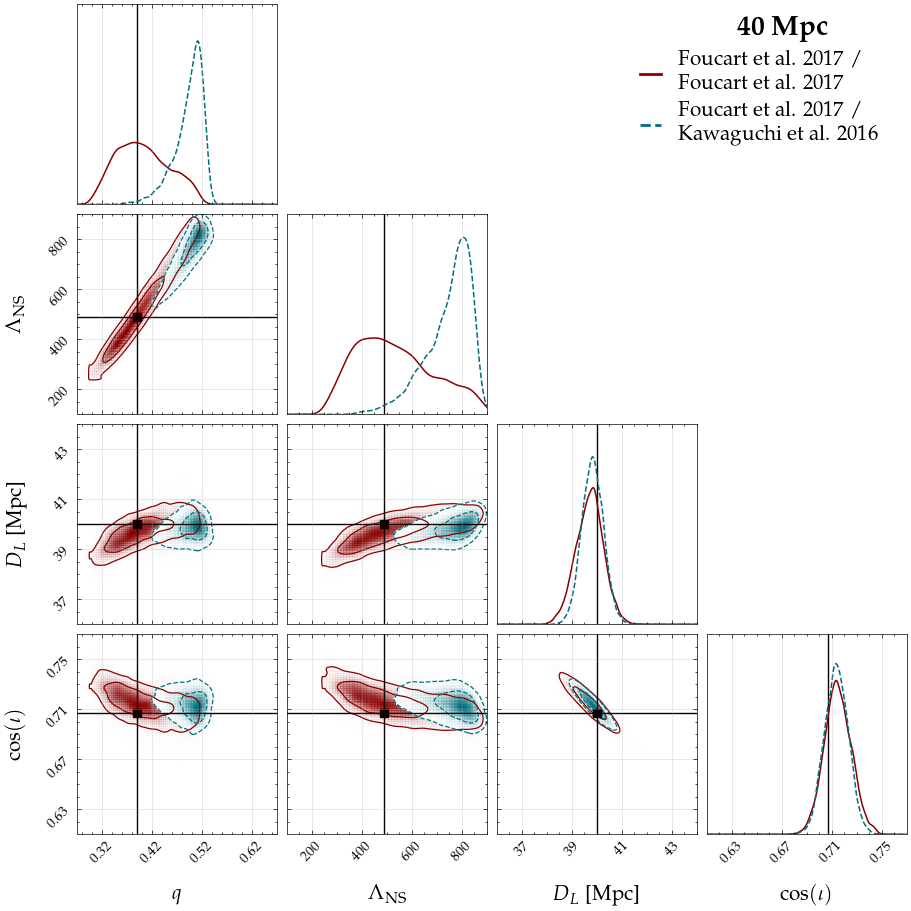

In [24]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['kruger_kruger', 'kruger_kawaguchi']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/40Mpc/dynamical_velocity_foucart_foucart/em_run_gw_parameters', 
                                                   label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/40Mpc/dynamical_velocity_foucart_kawaguchi/em_run_gw_parameters', 
                                                   label='em')]
COLORS_RUNS = {'kruger_kruger'               : COLORS_DICT['darkred'],
               'kruger_kawaguchi'         : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'kruger_kruger'        : '-',
                  'kruger_kawaguchi'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 40, 0.707]

fig = corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kruger'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kruger'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kawaguchi'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kawaguchi'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(10, 60, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.32, 0.42, 0.52, 0.62]
lambda_2_ticks              = [200, 400, 600, 800]
luminosity_distance_ticks   = [37, 39, 41, 43]
cos_theta_jn_ticks          = [0.63, 0.67, 0.71, 0.75]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.27, 0.67
lambda_2_min, lambda_2_max                           = 100, 900
luminosity_distance_min, luminosity_distance_max     = 36, 44
cos_theta_jn_min, cos_theta_jn_max                   = 0.63 - 0.02, 0.75 + 0.02
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['Foucart et al. 2017 /\n Foucart et al. 2017', 'Foucart et al. 2017 /\n Kawaguchi et al. 2016']
legend = plt.legend(handles, labels, loc=(-0.38, 3.43), fontsize=15)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{40 Mpc}",
            xy=(0.15, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_40Mpc_vdyn_kf.pdf")
fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_40Mpc_vdyn_kf.png")

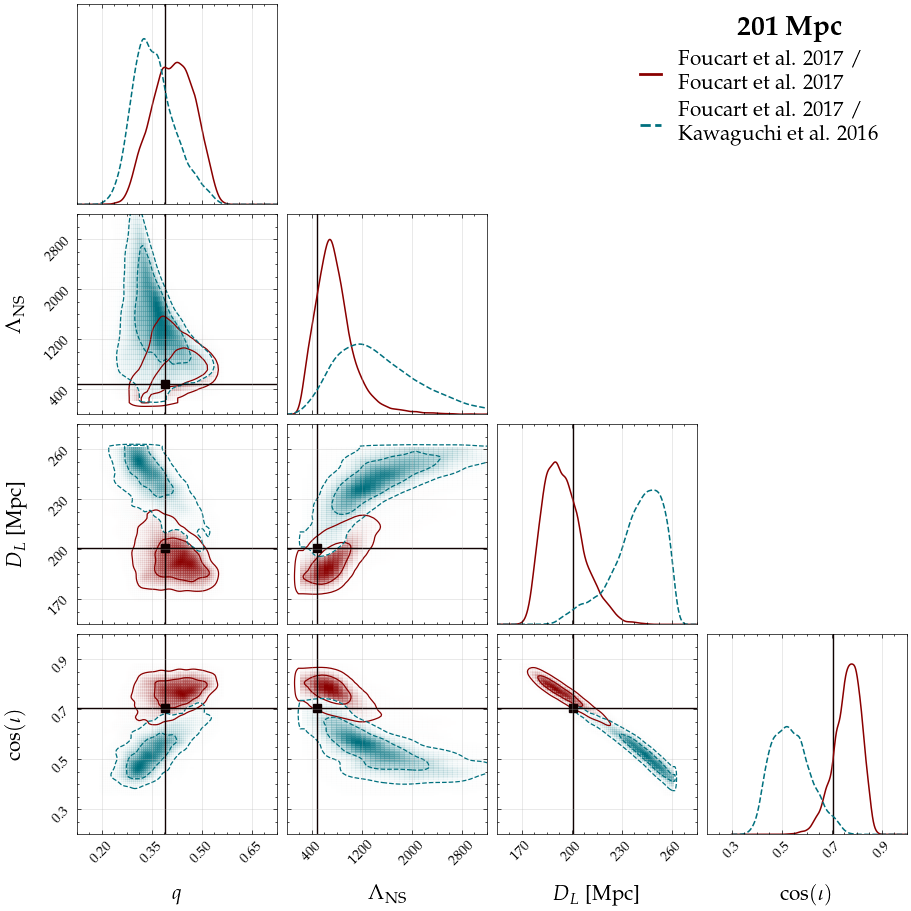

In [26]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['kruger_kruger', 'kruger_kawaguchi']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/201Mpc/dynamical_velocity_foucart_foucart/em_run_gw_parameters', 
                                                   label='em'),
                       bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/201Mpc/dynamical_velocity_foucart_kawaguchi/em_run_gw_parameters', 
                                                   label='em')]
COLORS_RUNS = {'kruger_kruger'               : COLORS_DICT['darkred'],
               'kruger_kawaguchi'         : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'kruger_kruger'        : '-',
                  'kruger_kawaguchi'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 201, 0.707]

fig = corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kruger'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kruger'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kawaguchi'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kawaguchi'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(120, 300, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.2, 0.35, 0.5, 0.65]
lambda_2_ticks              = [400, 1200, 2000, 2800]
luminosity_distance_ticks   = [170, 200, 230, 260]
cos_theta_jn_ticks          = [0.3, 0.5, 0.7, 0.9]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.125, 0.725
lambda_2_min, lambda_2_max                           = 0, 3200
luminosity_distance_min, luminosity_distance_max     = 155, 275
cos_theta_jn_min, cos_theta_jn_max                   = 0.2, 1
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['Foucart et al. 2017 /\n Foucart et al. 2017', 'Foucart et al. 2017 /\n Kawaguchi et al. 2016']
legend = plt.legend(handles, labels, loc=(-0.38, 3.43), fontsize=15)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{201 Mpc}",
            xy=(0.15, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_201Mpc_vdyn_kf.pdf")
fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_201Mpc_vdyn_kf.png")


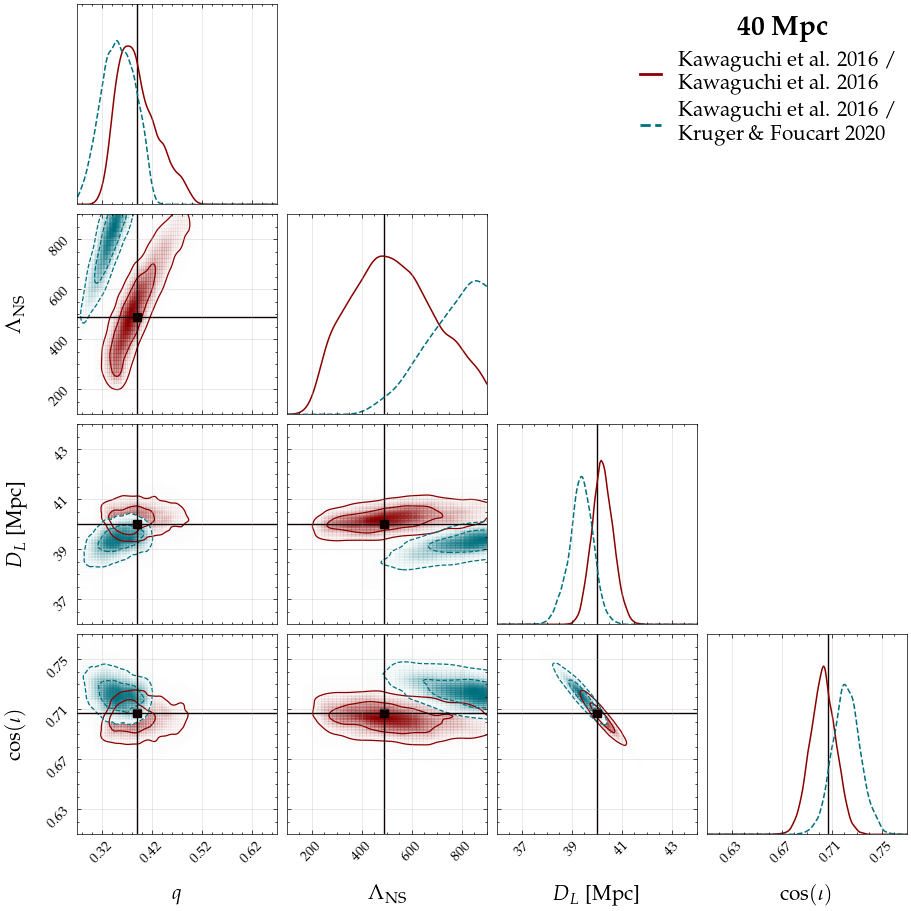

In [28]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['kruger_kruger', 'kruger_kawaguchi']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/40Mpc/dynamical_mass_kawaguchi_kawaguchi/em_run_gw_parameters', 
                                                   label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/40Mpc/dynamical_mass_kawaguchi_kruger/em_run_gw_parameters', 
                                                   label='em')]
COLORS_RUNS = {'kruger_kruger'               : COLORS_DICT['darkred'],
               'kruger_kawaguchi'         : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'kruger_kruger'        : '-',
                  'kruger_kawaguchi'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 40, 0.707]

fig = corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kruger'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kruger'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kawaguchi'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kawaguchi'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(10, 60, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.32, 0.42, 0.52, 0.62]
lambda_2_ticks              = [200, 400, 600, 800]
luminosity_distance_ticks   = [37, 39, 41, 43]
cos_theta_jn_ticks          = [0.63, 0.67, 0.71, 0.75]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.27, 0.67
lambda_2_min, lambda_2_max                           = 100, 900
luminosity_distance_min, luminosity_distance_max     = 36, 44
cos_theta_jn_min, cos_theta_jn_max                   = 0.63 - 0.02, 0.75 + 0.02
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['Kawaguchi et al. 2016 /\n Kawaguchi et al. 2016', 'Kawaguchi et al. 2016 /\n Kruger \& Foucart 2020']
legend = plt.legend(handles, labels, loc=(-0.38, 3.43), fontsize=15)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{40 Mpc}",
            xy=(0.15, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_40Mpc_mdyn_kk.pdf")
fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_40Mpc_mdyn_kk.png")

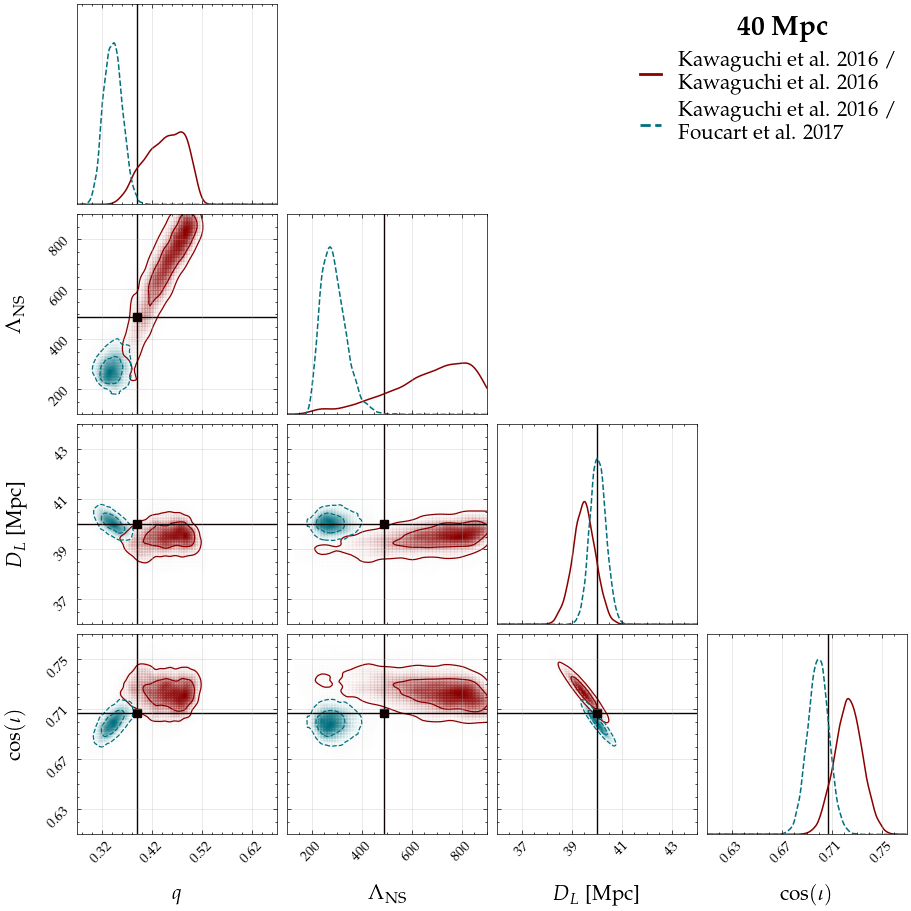

In [30]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['kruger_kruger', 'kruger_kawaguchi']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/40Mpc/dynamical_velocity_kawaguchi_kawaguchi/em_run_gw_parameters', 
                                                   label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/40Mpc/dynamical_velocity_kawaguchi_foucart/em_run_gw_parameters', 
                                                   label='em')]
COLORS_RUNS = {'kruger_kruger'               : COLORS_DICT['darkred'],
               'kruger_kawaguchi'         : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'kruger_kruger'        : '-',
                  'kruger_kawaguchi'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 40, 0.707]

fig = corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kruger'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kruger'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kawaguchi'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kawaguchi'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(10, 60, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.32, 0.42, 0.52, 0.62]
lambda_2_ticks              = [200, 400, 600, 800]
luminosity_distance_ticks   = [37, 39, 41, 43]
cos_theta_jn_ticks          = [0.63, 0.67, 0.71, 0.75]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.27, 0.67
lambda_2_min, lambda_2_max                           = 100, 900
luminosity_distance_min, luminosity_distance_max     = 36, 44
cos_theta_jn_min, cos_theta_jn_max                   = 0.63 - 0.02, 0.75 + 0.02
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['Kawaguchi et al. 2016 /\n Kawaguchi et al. 2016', 'Kawaguchi et al. 2016 /\n Foucart et al. 2017']
legend = plt.legend(handles, labels, loc=(-0.38, 3.43), fontsize=15)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{40 Mpc}",
            xy=(0.15, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_40Mpc_vdyn_kk.pdf")
fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_40Mpc_vdyn_kk.png")

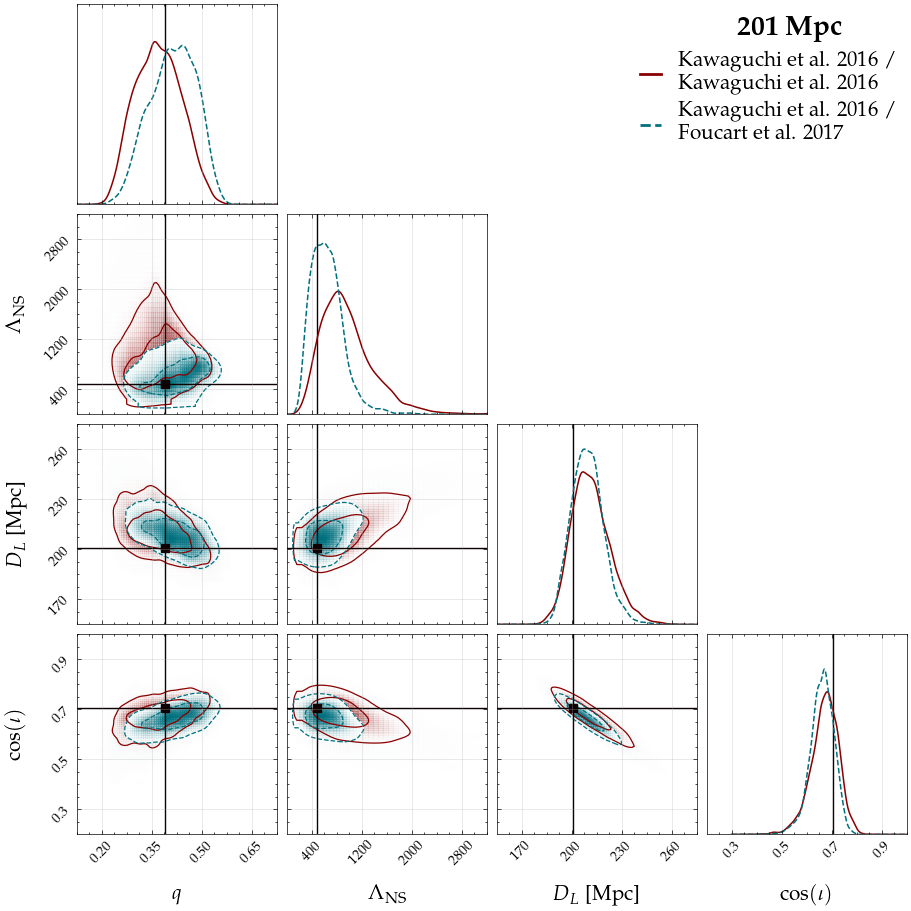

In [32]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['kruger_kruger', 'kruger_kawaguchi']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/201Mpc/dynamical_velocity_kawaguchi_kawaguchi/em_run_gw_parameters', 
                                                   label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/201Mpc/dynamical_velocity_kawaguchi_foucart/em_run_gw_parameters', 
                                                   label='em')]
COLORS_RUNS = {'kruger_kruger'               : COLORS_DICT['darkred'],
               'kruger_kawaguchi'         : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'kruger_kruger'        : '-',
                  'kruger_kawaguchi'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 201, 0.707]

fig = corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kruger'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kruger'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kawaguchi'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kawaguchi'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(120, 300, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.2, 0.35, 0.5, 0.65]
lambda_2_ticks              = [400, 1200, 2000, 2800]
luminosity_distance_ticks   = [170, 200, 230, 260]
cos_theta_jn_ticks          = [0.3, 0.5, 0.7, 0.9]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.125, 0.725
lambda_2_min, lambda_2_max                           = 0, 3200
luminosity_distance_min, luminosity_distance_max     = 155, 275
cos_theta_jn_min, cos_theta_jn_max                   = 0.2, 1
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['Kawaguchi et al. 2016 /\n Kawaguchi et al. 2016', 'Kawaguchi et al. 2016 /\n Foucart et al. 2017']
legend = plt.legend(handles, labels, loc=(-0.38, 3.43), fontsize=15)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{201 Mpc}",
            xy=(0.15, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_201Mpc_vdyn_kk.pdf")
fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_201Mpc_vdyn_kk.png")


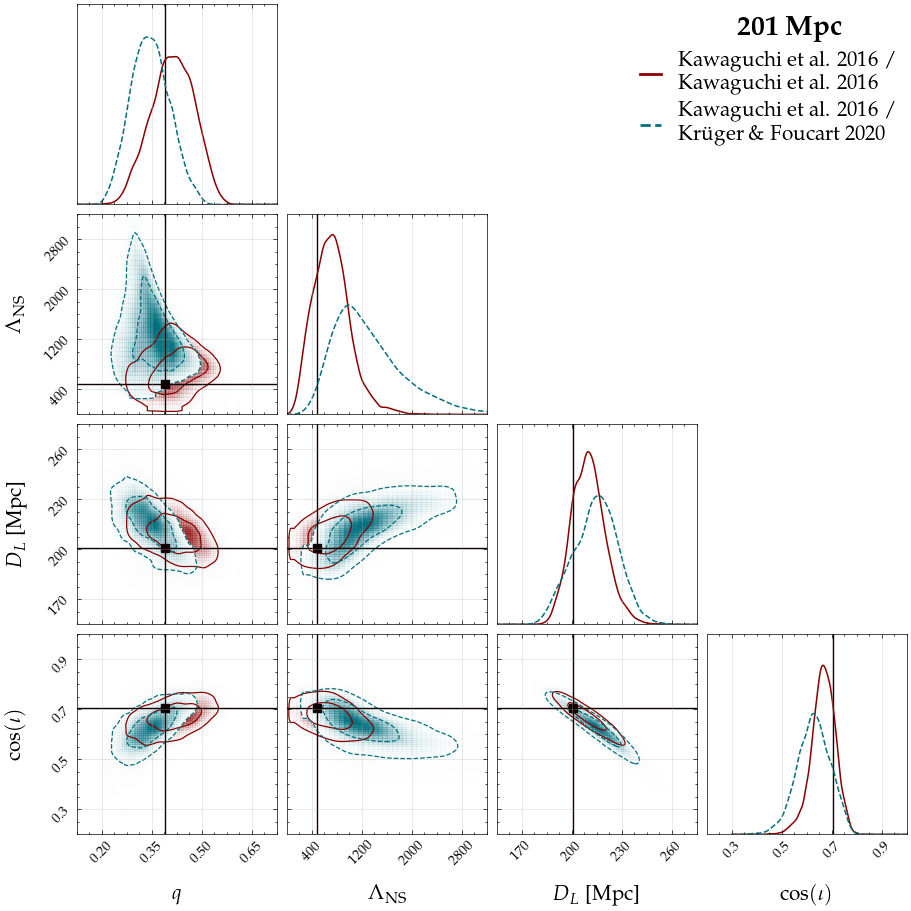

In [34]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['kruger_kruger', 'kruger_kawaguchi']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/201Mpc/dynamical_mass_kawaguchi_kawaguchi/em_run_gw_parameters', 
                                                   label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/201Mpc/dynamical_mass_kawaguchi_kruger/em_run_gw_parameters', 
                                                   label='em')]
COLORS_RUNS = {'kruger_kruger'               : COLORS_DICT['darkred'],
               'kruger_kawaguchi'         : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'kruger_kruger'        : '-',
                  'kruger_kawaguchi'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 201, 0.707]

fig = corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kruger'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kruger'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kawaguchi'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kawaguchi'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(120, 300, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.2, 0.35, 0.5, 0.65]
lambda_2_ticks              = [400, 1200, 2000, 2800]
luminosity_distance_ticks   = [170, 200, 230, 260]
cos_theta_jn_ticks          = [0.3, 0.5, 0.7, 0.9]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.125, 0.725
lambda_2_min, lambda_2_max                           = 0, 3200
luminosity_distance_min, luminosity_distance_max     = 155, 275
cos_theta_jn_min, cos_theta_jn_max                   = 0.2, 1
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['Kawaguchi et al. 2016 /\n Kawaguchi et al. 2016', 'Kawaguchi et al. 2016 /\n Krüger \& Foucart 2020']
legend = plt.legend(handles, labels, loc=(-0.38, 3.43), fontsize=15)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{201 Mpc}",
            xy=(0.15, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_201Mpc_mdyn_kk.pdf")
fig.savefig(figures_dir + "case_studies/case_study_3_corner_plot_comparison_201Mpc_mdyn_kk.png")


In [46]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
detector_key = ['O4', 'O5', 'O6']

for detector in detector_key:
    label_key = ['em', 'gw']

    results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_4/{detector}/em_run/', label='em'),
                    bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_4/{detector}/gw_run/', label='gw')]
    COLORS_RUNS = {'em'               : COLORS_DICT['darkred'],
                'gw'               : COLORS_DICT['teal']}

    LINESTYLE_RUNS = {'em'        : '-',
                    'gw'     : '--'}
    direction  = "in"
    smoothing  = 1.8
    nbins      = 60

    posteriors = ['mass_ratio', 'lambda_2', 'chi_1', 'luminosity_distance', 'cos_theta_jn']
    param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$\chi_{\rm BH}$', '$D_L$ [Mpc]', r'$\cos(\iota)$']
    truth_values = [0.39, 490.32033763361954, 0.44, 201, 0.707]

    fig = corner.corner(
        np.array([results_list[1].posterior[key] for key in posteriors]).T,
        bins            = nbins,
        labels          = param_labels,
        fill_contours   = False,
        plot_datapoints = False,
        color           = COLORS_RUNS['gw'],
        smooth          = smoothing,
        levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
        plot_kwargs     = dict(linestyle = "-"),
        hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
        contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['gw'], linewidths=[LINEWIDTHS["curve"]]),
        plot_density    = True,
    )

    corner.corner(
        np.array([results_list[0].posterior[key] for key in posteriors]).T,
        fig             = fig,
        bins            = nbins,
        labels          = param_labels,
        fill_contours   = False,
        plot_datapoints = False,
        color           = COLORS_RUNS['em'],
        smooth          = smoothing,
        truths          = truth_values,
        truth_color     = COLORS_DICT["black"],
        levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
        plot_kwargs     = dict(linestyle = "-"),
        hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
        contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['em'], linewidths=[LINEWIDTHS["curve"]]),
        plot_density    = True,
        labelpad        = -0.05,
    )
    # Evaluate KDE
    kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
    kde_chirp_mass              = [gaussian_kde(results_list[i].posterior["chirp_mass"].to_numpy()) for i in range(len(results_list))]
    kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
    kde_chi_1                   = [gaussian_kde(results_list[i].posterior["chi_1"].to_numpy()) for i in range(len(results_list))]
    kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
    kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

    kdes = [kde_mass_ratio, kde_lambda_2, kde_chi_1, kde_luminosity_distance, kde_cos_theta_jn]
    kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 5000, 1000), 
                np.linspace(0.0, 1, 1000), np.linspace(100, 320, 100),  np.linspace(0.1, 1, 1000)]

    mass_ratio_ticks            = [0.36, 0.38, 0.40, 0.42]
    chirp_mass_ticks            = (np.array([-0.0001, 0.0002, 0.0005, 0.0008]) + 1.91).tolist()
    lambda_2_ticks              = [400, 475, 550, 625]
    chi_1_ticks                 = [0.432, 0.440, 0.448, 0.456]
    luminosity_distance_ticks   = [190, 198, 206, 214]
    cos_theta_jn_ticks          = [0.64, 0.68, 0.72, 0.76]


    for j, axes in enumerate([0, 6, 12, 18, 24]):
        for i, label in enumerate(label_key):
            fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

    corner.corner(
                np.array([results_list[i].posterior[key] for key in posteriors]).T,
                fig             = fig,
                bins            = nbins,
                labels          = param_labels,
                fill_contours   = False,
                plot_datapoints = False,
                color           = COLORS_RUNS[label],
                smooth          = smoothing,
                truths          = truth_values,
                truth_color     = COLORS_DICT["black"],
                levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
                plot_kwargs     = dict(linestyle = "-"),
                hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
                contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
                plot_density    = True,
                labelpad        = -0.05,
            )


    # add the legend to the plot
    handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls='-'),
               Line2D([], [], color=COLORS_DICT["teal"], ls='--')]

    labels = [r'EM', r'GW']
    legend = plt.legend(handles, labels, loc=(0.30, 4.8), fontsize=24)
    for i in legend.legend_handles:
        i.set_linewidth(3)

    # # matplotlib.rcParams['axes.formatter.useoffset'] = False

    fig.savefig(figures_dir + f"case_studies/case_study_4_{detector}_em_gw_network_corner_plot_combined.pdf")
    fig.savefig(figures_dir + f"case_studies/case_study_4_{detector}_em_gw_network_corner_plot_combined.png")
    plt.clf()

<Figure size 1180x1180 with 0 Axes>

<Figure size 1180x1180 with 0 Axes>

<Figure size 1180x1180 with 0 Axes>

In [67]:


import pandas as pd


O4_dataframe_10yr = [pd.read_csv(f'data/results/population_studies/population_injections/O4/2_analysed_results_network=O4_t=1yr_snr=12_{i}.txt') for i in range(10)]
O5_dataframe_10yr = [pd.read_csv(f'data/results/population_studies/population_injections/O5/2_analysed_results_network=O5_t=1yr_snr=12_{i}.txt') for i in range(10)]
O6_dataframe_10yr = [pd.concat([pd.read_csv(f'data/results/population_studies/population_injections/O6/folder_{j}/2_analysed_results_network=O6_snr=12_batch_number={i}.txt') for i in range(7)]) for j in range(10)]
G3_dataframe_10yr = [pd.concat([pd.read_csv(f'data/results/population_studies/population_injections/3G/folder_{j}/2_analysed_results_network=3G_snr=12_batch_number={i}.txt') for i in range(12)]) for j in range(10)]

O4_dataframe_1yr = O4_dataframe_10yr[1]
O5_dataframe_1yr = O5_dataframe_10yr[0]
O6_dataframe_1yr = O6_dataframe_10yr[0]
G3_dataframe_1yr = G3_dataframe_10yr[0]

LIMTING_MAGNITUDES = {'LSST_g': 25.872689062979553, 'LSST_r': 25.372689062979553, 'LSST_y': 23.572689062979556, 'LSST_u': 24.672689062979554, 
                      'LSST_z': 24.372689062979553, 'LSST_i': 24.972689062979555, 'ZTF_g': 22.35, 'ZTF_r': 21.85, 'ZTF_i': 21.45}

color = list(reversed([COLORS_DICT['orange'], COLORS_DICT['gray'], COLORS_DICT['teal'], COLORS_DICT['darkred']]))

for band in ['z', 'u', 'y']:
    fig, ax = plt.subplots(figsize=[7, (4 / 7) * 8])
    for j, dataframe in enumerate(reversed([pd.concat(O4_dataframe_10yr), pd.concat(O5_dataframe_10yr), pd.concat(O6_dataframe_10yr), pd.concat(G3_dataframe_10yr)])):
        
        ax.plot(dataframe['err_sky_location_90'], dataframe[f'peak_{band}_band'], 'o', color=color[j], markersize=2)
        ax.set_xlim(1e-3, 1e3)
        ax.set_ylim(17.5, 38)
        ax.set_xscale('log')

        ax.vlines([9.6, 96], ymin=17.5, ymax=38, linestyle='--', color='black', linewidth=0.5)
        #ax.vlines([47, 470], ymin=17.5, ymax=38, linestyle='-.', color='black', linewidth=0.5)

        ax.hlines([LIMTING_MAGNITUDES[f'LSST_{band}']], xmin=1e-3, xmax=1e3, linestyle='--', color='black', linewidth=0.5)
        #ax.hlines([LIMTING_MAGNITUDES[f'ZTF_{band}']], xmin=1e-3, xmax=1e3, linestyle='-.', color='black', linewidth=0.5)

    ax.set_xlabel(r'$\Delta \Omega_{90\%}$ [deg$^2$]', fontsize=13)
    ax.set_ylabel(r'Peak AB magnitude', fontsize=13)

    # ax.annotate(r"\textbf{{ZTF}} (${band}-\text{{filter}}$) $m_{{\rm lim}}$".format(band=band),
    #                 xy=(10**-2.93, LIMTING_MAGNITUDES[f'ZTF_{band}'] - 0.18), 
    #                 xycoords='data',
    #                 size=8,
    #                 weight='black')

    ax.annotate(r"\textbf{{LSST}} (${band}-\text{{filter}}$) $m_{{\rm lim}}$".format(band=band),
                    xy=(10**-2.93, LIMTING_MAGNITUDES[f'LSST_{band}'] - 0.18), 
                    xycoords='data',
                    size=8,
                    weight='black')

    ax.annotate(r"$\textbf{LSST} - \text{FOV}$",
                    xy=(9.9, 21.2), 
                    xycoords='data',
                    size=8,
                    weight='black',
                    rotation=-90)

    # ax.annotate(r"$\textbf{ZTF} - \text{FOV}$",
    #                 xy=(47.4, 21.), 
    #                 xycoords='data',
    #                 size=8,
    #                 weight='black',
    #                 rotation=-90)

    ax.annotate(r"$\textbf{LSST} - 10 \times \text{FOV}$",
                    xy=(100.4, 22.6), 
                    xycoords='data',
                    size=8,
                    weight='black',
                    rotation=-90)

    # ax.annotate(r"$\textbf{ZTF} - 10 \times \text{FOV}$",
    #                 xy=(500, 37.5), 
    #                 xycoords='data',
    #                 size=8,
    #                 weight='black',
    #                 rotation=-90)

    plt.gca().invert_yaxis()

    ax.set_yticks([38, 34, 30, 26, 22, 18])

    labels = [r"$\textbf{3G}$", 
            r"\textbf{O6}",
            r"\textbf{O5}",
            r"\textbf{O4}"]

    handles = reversed([Line2D([], [], color=COLORS_DICT["orange"], marker='o', linestyle='None',  markersize=4), 
            Line2D([], [], color=COLORS_DICT["gray"], marker='o', linestyle='None',  markersize=4),
            Line2D([], [], color=COLORS_DICT["teal"], marker='o', linestyle='None',  markersize=4),
            Line2D([], [], color=COLORS_DICT["darkred"], marker='o', linestyle='None',  markersize=4),
            ])

    legend = plt.legend(handles, labels, loc='lower left', fontsize=11, numpoints=1)
    for i in legend.legend_handles:
        i.set_linewidth(2)

    ax.tick_params(axis='x', which='major', pad=6)

    fig.savefig(figures_dir + f"population_studies/kn_detections_{band}_band.png")
    fig.savefig(figures_dir + f"population_studies/kn_detections_{band}_band.pdf")
    plt.clf()

/home/smelfor/anaconda3/envs/plotting_env/lib/python3.10/site-packages/matplotlib/ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


<Figure size 700x457.143 with 0 Axes>

<Figure size 700x457.143 with 0 Axes>

<Figure size 700x457.143 with 0 Axes>